# Dataworth with Freyberg Pilot Points Model

### Here we are going to investigate the sources of forecast uncertainty as well as the worth of observations to reduce forecast uncertainty.  This is essentially the same workflow as used with the ``freyberg_zone_dataworth`` excersize.  Important things to remember:
### - FOSM doesn't require values for observations, parameters or forecast.  We do need sensitivities between the quantities and estimates of prior uncertainties for parameters and observtion noise.  
- 

In [1]:
%matplotlib inline
import os
import sys
sys.path.append("..")
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import pyemu

In [2]:
import freyberg_setup as fs
fs.setup_pest_pp()
working_dir = fs.WORKING_DIR_PP
pst_name = fs.PST_NAME_PP

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...

changing model workspace...
   freyberg_pp
FloPy is using the following executable to run the model: /Users/jeremyw/Dev/gw1876/activities/freyberg_pilot_points_dataworth/freyberg_pp/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.1.1, 7/21/2016                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.04.0 07/21/2016                       

 Using NAME file: freyberg.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/04/27 11:17:18

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  

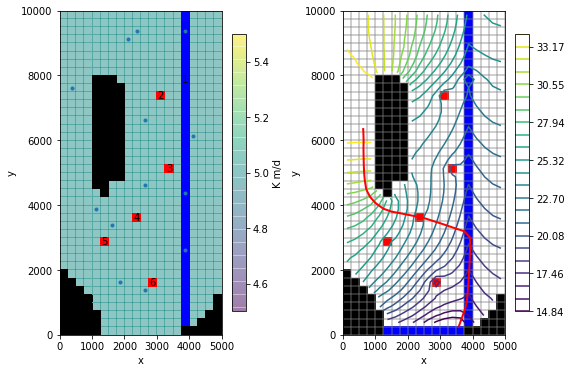

In [3]:
fs.plot_model(working_dir, pst_name)

In [5]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
par = pst.parameter_data
par.loc[par.parnme.apply(lambda x: x.startswith("w")),"partrans"] = "fixed"
pst.control_data.noptmax = -1
pst.write(os.path.join(working_dir,pst_name))


In [6]:
os.chdir(working_dir)
pyemu.helpers.start_slaves('.',"pestpp",pst_name,num_slaves=15,master_dir=".")
os.chdir("..")

In [9]:
sc = pyemu.Schur(os.path.join(working_dir,pst_name.replace(".pst",".jcb")),verbose=False)

### A quick check of which parameters are being informed by the observations during calibration:

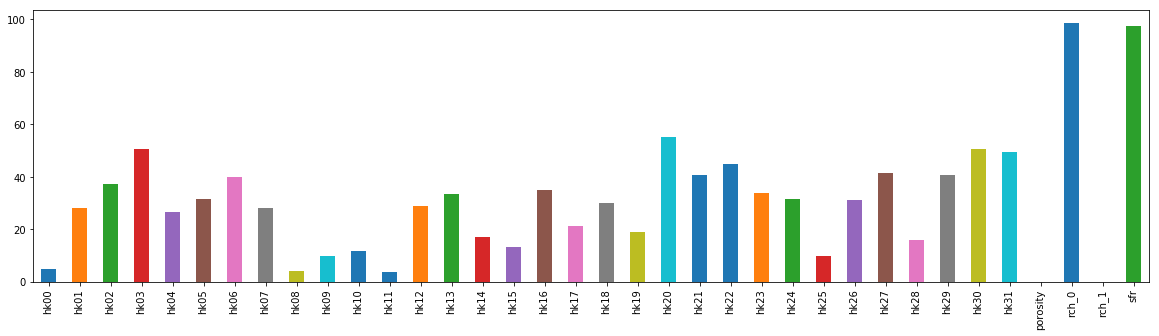

In [10]:
fig = plt.figure(figsize=(20,5))
ax = plt.subplot(111)
sc.get_parameter_summary().percent_reduction.plot(kind="bar",ax=ax)

## Parameter contribution analysis

### We are going to use the ``Schur.get_par_contribution()`` method. It calculates the *decrease* in forecast uncertainty resulting for hypothetical "perfect knowledge" (no uncertainty) of arbitrary groups of parameters. If you don't pass any arguments, then it tests each parameter independently:

In [12]:
df_pc = sc.get_par_contribution()
df_pc

,c001fr05c04_19791231,c001fr16c17_19791231,fa_headwaters_0001,travel_time
base,1.890567,0.124525,371051.771384,5.867986e+07
hk23,1.883656,0.124443,370865.037608,5.795565e+07
hk20,1.890061,0.124505,371034.935753,5.850681e+07
hk28,1.889179,0.124519,370929.177358,4.791619e+07
hk19,1.888797,0.123297,371048.211653,5.805482e+07
hk02,1.890074,0.124506,370643.666673,5.867353e+07
rch_0,1.886720,0.124373,370903.872109,5.692515e+07
hk26,1.890372,0.124331,371017.178470,5.830222e+07
hk30,1.890033,0.124511,371044.501464,5.657262e+07
hk15,1.890482,0.123316,371023.896970,5.860657e+07


In [13]:
df_pc = 100.0 * (1.0 - df_pc / df_pc.loc["base",:])

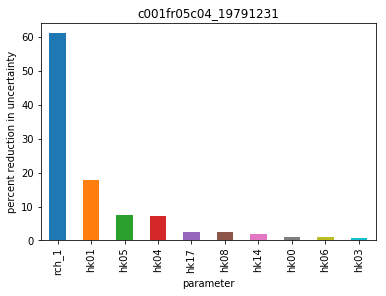

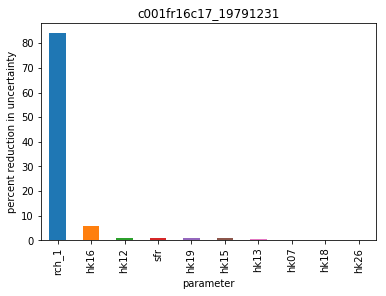

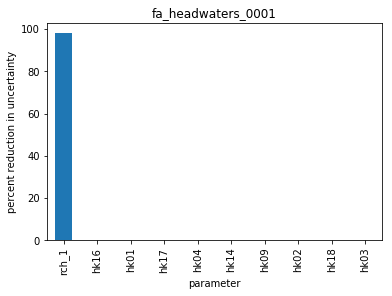

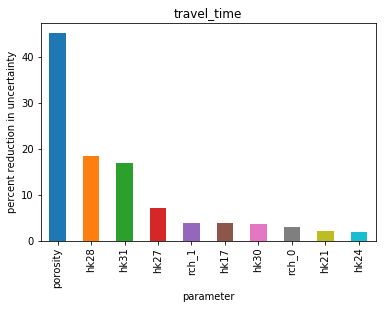

In [14]:
for forecast in df_pc.columns:
    ax = df_pc.sort_values(by=forecast,ascending=False).loc[:,forecast].iloc[:10].plot(kind="bar")
    ax.set_title(forecast)
    ax.set_ylabel("percent reduction in uncertainty")
    ax.set_xlabel("parameter")
    plt.show()


### We see a mixture of HK pilot points, recharge, and well pumping rates...so we see that each forecast depends on (potentailly) difference combinations of parameters.  Does this mean we can still make a model that makes several kinds of forecasts???

## Observation worth

### Let's see what observations are most important to the forecasts.  We will start be investigating the value of the existing observations using the ``Schur.get_removed_obs_importance()`` method.  It calculates the *increase* in forecast uncertainty that happens if we lose each existing observation. We will start with the existing observations:

In [15]:
df_rm = sc.get_removed_obs_importance()
df_rm

,c001fr05c04_19791231,c001fr16c17_19791231,fa_headwaters_0001,travel_time
base,1.890567,0.124525,371051.771384,5.867986e+07
c001cr34c08_19700102,1.891061,0.124556,371058.892847,6.154888e+07
c001cr22c11_19700102,1.890582,0.127267,371731.803519,5.883803e+07
c001cr27c07_19700102,1.894562,0.125150,371353.191986,6.026214e+07
c001cr03c16_19700102,1.903368,0.124715,371518.173531,5.874734e+07
c001cr35c11_19700102,1.897368,0.124612,371565.288764,7.643014e+07
c001cr10c02_19700102,3.030128,0.124549,371223.719974,5.872983e+07
c001cr04c09_19700102,2.184422,0.124529,371054.191903,5.878005e+07
c001cr03c10_19700102,2.020973,0.124527,371109.534567,5.870288e+07
fo_seg_40_0000,2.011411,0.131400,386779.686891,6.391105e+07


In [16]:
df_rm = 100.0 * (1.0 - df_rm.loc["base",:] / df_rm)

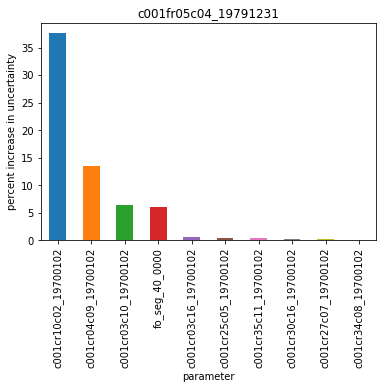

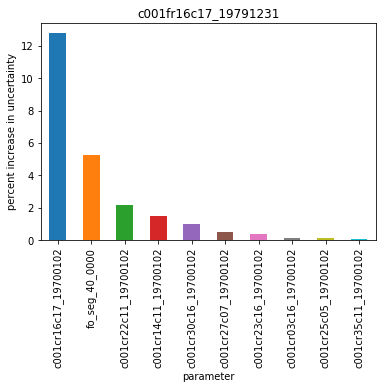

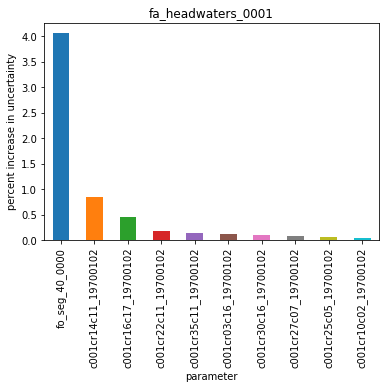

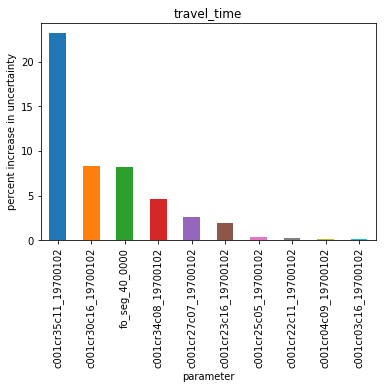

In [17]:
for forecast in df_rm.columns:
    ax = df_rm.sort_values(by=forecast,ascending=False).loc[:,forecast].iloc[:10].plot(kind="bar")
    ax.set_title(forecast)
    ax.set_ylabel("percent increase in uncertainty")
    ax.set_xlabel("parameter")
    plt.show()

### Estimating the value of yet-to-be-collected observations

### Using the assumptions of FOSM, we can also calculate the value of observations we don't have yet!  Black magic!  

### Not really, we carried these possible data locations as ``observations`` in the control file - this means each one has a row in the jacobian (just like any other output of interest).  If we then assume some value of measurement noise (a non-zero weight in the control file), we can run a hypothetical "calibration" analysis using Schur compliment.  Remember, FOSM doesn't care about actual values of parameters, observations, or forecasts, only sensitivities...

### In pyemu, the ``Schur.get_added_obs_importance()`` method calculates the *decrease* in uncertainty resulting for having new obsevations during calibration.  It accepts an optional argument ``obslist_dict`` which is a python dictionary of groups of new observations to test.  

### Here we will test the value of having the water level in each unmeasured model cell.  Then we can make maps of where to collect new data...these calculations take a little while to run because we are repeatedly calculating the entire FOSM process for each new observation location 

In [18]:
pobs_names = [o for o in sc.pst.obs_names if "pr" in o and "19700102" in o]
df_ad = sc.get_added_obs_importance(obslist_dict={oname:oname for oname in pobs_names},
                                base_obslist=sc.pst.nnz_obs_names,reset_zero_weight=5.0)

In [19]:
df_ad.min()

c001fr05c04_19791231    1.214360e+00
c001fr16c17_19791231    1.134658e-01
fa_headwaters_0001      3.690705e+05
travel_time             3.945037e+07
dtype: float64

In [20]:
df_ad.max()

c001fr05c04_19791231    1.890567e+00
c001fr16c17_19791231    1.245249e-01
fa_headwaters_0001      3.710518e+05
travel_time             5.867986e+07
dtype: float64

In [21]:
# just a helper function to make maps of data worth
m = flopy.modflow.Modflow.load(fs.MODEL_NAM,model_ws=working_dir)
obs = pst.observation_data
hobs = obs.loc[obs.obgnme=="calhead",:].copy()
hobs.loc[:,"i"] = hobs.obsnme.apply(lambda x: int(x[6:8])-1)
hobs.loc[:,"j"] = hobs.obsnme.apply(lambda x: int(x.split('_')[0].split('c')[-1])-1)
hobs.loc[:,"x"] = m.sr.xcentergrid[hobs.i,hobs.j]
hobs.loc[:,"y"] = m.sr.ycentergrid[hobs.i,hobs.j]
wdata = pd.DataFrame.from_records(m.wel.stress_period_data[0])
wdata.loc[:,"x"] = m.sr.xcentergrid[wdata.i,wdata.j]
wdata.loc[:,"y"] = m.sr.ycentergrid[wdata.i,wdata.j]
pp_df = pyemu.pp_utils.pp_file_to_dataframe(os.path.join(working_dir,"hkpp.dat"))
def plot_added_worth(df):
    df_base = df.loc["base",:]
    df_frac = 100.0 * (1.0 - (df / df_base))
    df_frac = df_frac.loc[pobs_names,:]
    df_frac.loc[:,"i"] = df_frac.index.map(lambda x: int(x[6:8])-1)
    df_frac.loc[:,"j"] = df_frac.index.map(lambda x: int(x[9:11])-1)
    #print(df_frac.)
    for forecast in sc.pst.forecast_names:
        print(forecast)
        arr = np.zeros((m.nrow,m.ncol)) - 1
        arr[df_frac.i,df_frac.j] = df_frac.loc[:,forecast]
        arr = np.ma.masked_where(arr < 0.0 ,arr)
        fig = plt.figure(figsize=(12,10))
        
        ax = plt.subplot(111,aspect="equal")
        c = ax.pcolormesh(m.sr.xedge,m.sr.yedge,arr,alpha=0.75)
        plt.colorbar(c)
        #if forecast.startswith("fr"):
        #    i = int(forecast[2:4]) - 1
        #    j = int(forecast.split('_')[0].split('c')[-1]) - 1
        #    x,y = m.sr.xcentergrid[i,j],m.sr.ycentergrid[i,j]
        #    ax.scatter([x],[y],marker='o',color='r',s=150)
            #ax2.scatter([x],[y],marker='o',color='r',s=150)    
        ax.scatter(hobs.x,hobs.y,marker='x',s=100,color='y')
        ax.scatter(wdata.x,wdata.y,marker='*',s=100,color='m')
        ax.scatter(pp_df.x,pp_df.y,marker='.',color='w',s=50)
        ax.set_title(forecast)
        
        plt.show()
        plt.close(fig)
    

### Now we are going to plot the worth (reduction in uncertainty) of a single, new water level measurement for each forecast (forecast name is the title of each plot). So these plots show us where to go collect new data to reduce forecast uncertainty as much as possible...red circles show the forecast (for water level forecasts), yellow X's are the locations of existing water levels, purple stars mark pumping well locations (pumping rates are treated as uncertain!)

travel_time


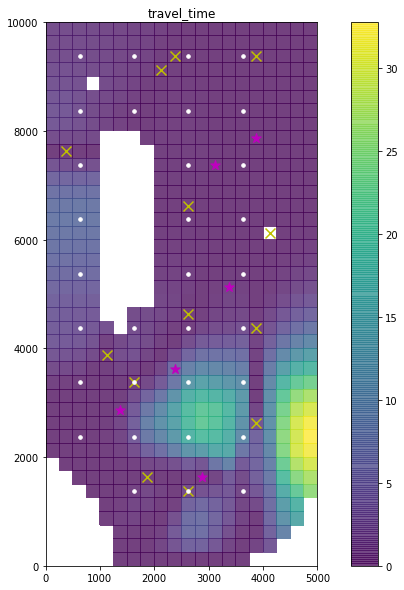

fa_headwaters_0001


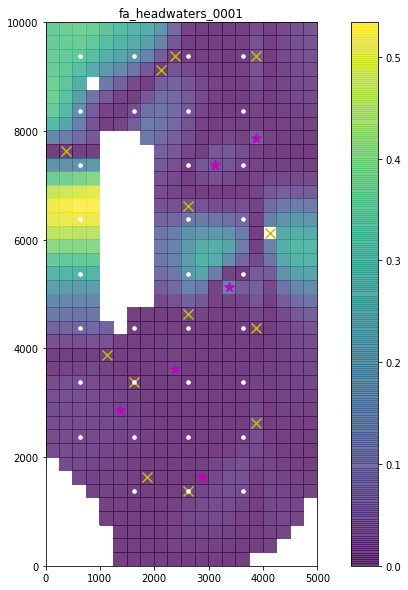

c001fr16c17_19791231


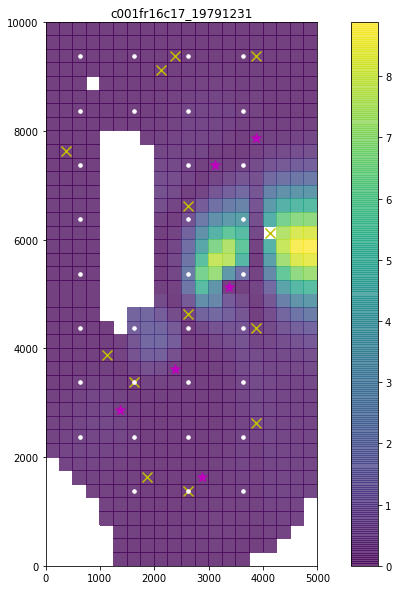

c001fr05c04_19791231


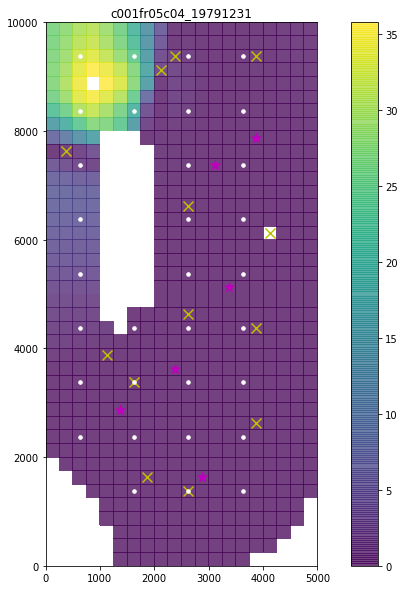

In [22]:
plot_added_worth(df_ad)

In [23]:
sc.pst.nnz_obs_names

['c001cr03c10_19700102',
 'c001cr03c16_19700102',
 'c001cr04c09_19700102',
 'c001cr10c02_19700102',
 'c001cr14c11_19700102',
 'c001cr16c17_19700102',
 'c001cr22c11_19700102',
 'c001cr23c16_19700102',
 'c001cr25c05_19700102',
 'c001cr27c07_19700102',
 'c001cr30c16_19700102',
 'c001cr34c08_19700102',
 'c001cr35c11_19700102',
 'fo_seg_40_0000']

Ok, so those are cool.  And, unlike the zoned-parameterization dataworth, these make sense from a physical interpretation standpoint

Let's explore what happens when we use a full covariance prior

In [24]:
v = pyemu.geostats.ExpVario(contribution=1.0,a=2500.0)
gs = pyemu.geostats.GeoStruct(variograms=[v])
cov = pyemu.helpers.pilotpoint_prior_builder(sc.pst,
                            struct_dict={gs:os.path.join(working_dir,"hkpp.dat.tpl")})

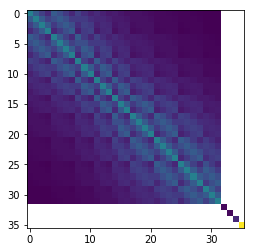

In [25]:
x = np.ma.masked_where(cov.x==0,cov.x)
plt.imshow(x)

In [26]:
sc_full = pyemu.Schur(jco=sc.jco,pst=sc.pst,parcov=cov,forecasts=sc.forecasts,verbose=True)

2018-04-27 11:32:58.030915 starting: pre-loading base components
2018-04-27 11:32:58.031029 starting: loading obscov
2018-04-27 11:32:58.121414 finished: loading obscov took: 0:00:00.090385
2018-04-27 11:32:58.121485 starting: loading forecasts
2018-04-27 11:32:58.122833 finished: loading forecasts took: 0:00:00.001348
2018-04-27 11:32:58.122873 forecast names: travel_time,fa_headwaters_0001,c001fr16c17_19791231,c001fr05c04_19791231
2018-04-27 11:32:58.122891 finished: pre-loading base components took: 0:00:00.091976
2018-04-27 11:32:58.122908 starting: dropping prior information
2018-04-27 11:32:58.123483 starting: removing 0 prior info from jco, pst, and obs cov
2018-04-27 11:32:58.124899 finished: removing 0 prior info from jco, pst, and obs cov took: 0:00:00.001416
2018-04-27 11:32:58.124935 finished: dropping prior information took: 0:00:00.002027


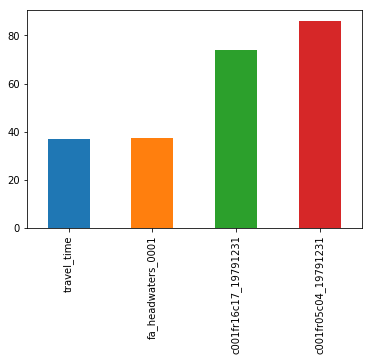

In [27]:
sc.get_forecast_summary().sort_values(by='percent_reduction').percent_reduction.plot(kind="bar")

In [28]:
df_full = sc_full.get_forecast_summary()
df_full.loc[:,"full"] = df_full.percent_reduction
df_full.loc[:,"diag"] = sc.get_forecast_summary().percent_reduction

2018-04-27 11:33:12.265944 starting: propagating prior to predictions
2018-04-27 11:33:12.273130 finished: propagating prior to predictions took: 0:00:00.007186
2018-04-27 11:33:12.273224 starting: propagating posterior to predictions
2018-04-27 11:33:12.273506 starting: Schur's complement
2018-04-27 11:33:12.274035 starting: xtqx
2018-04-27 11:33:12.314210 finished: xtqx took: 0:00:00.040175
2018-04-27 11:33:12.314758 finished: Schur's complement took: 0:00:00.041252
2018-04-27 11:33:12.315091 finished: propagating posterior to predictions took: 0:00:00.041867


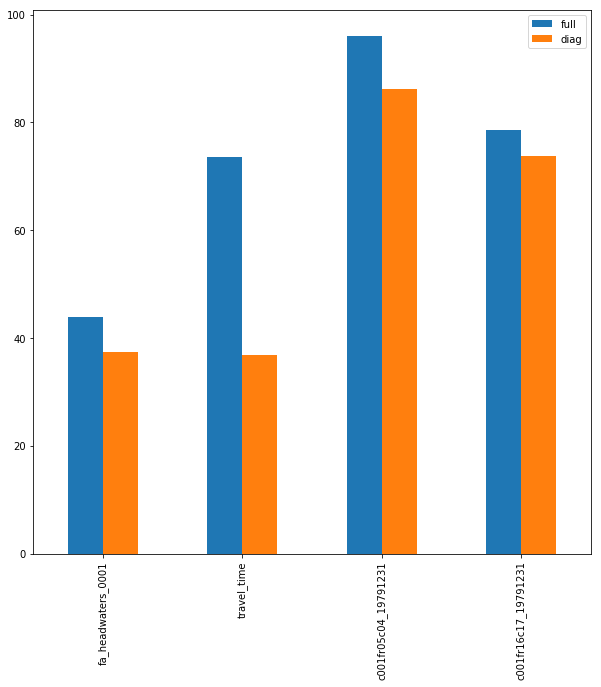

In [29]:
df_full.loc[:,["full","diag"]].plot(kind="bar",figsize=(10,10))

### Why did percent reduction increase for all forecasts increase???

In [30]:
df_full.prior_var

fa_headwaters_0001      6.613755e+05
travel_time             1.985125e+08
c001fr05c04_19791231    4.266138e+01
c001fr16c17_19791231    5.467822e-01
Name: prior_var, dtype: float64

In [31]:
sc.get_forecast_summary().prior_var

fa_headwaters_0001      5.926750e+05
travel_time             9.301635e+07
c001fr05c04_19791231    1.363342e+01
c001fr16c17_19791231    4.752363e-01
Name: prior_var, dtype: float64

### Let's recalculate the value of possible new observations...this takes longer now that we are using a full covaraince matrix because the repeated matrix-matrix products...

In [32]:
df_full = sc_full.get_added_obs_importance(obslist_dict={oname:oname for oname in pobs_names},
                                base_obslist=sc.pst.nnz_obs_names,reset_zero_weight=5.0)

2018-04-27 11:34:33.770972 resetting zero weights to 5.0
2018-04-27 11:34:33.782437 starting: resetting zero weight obs in base_obslist
2018-04-27 11:34:33.805938 finished: resetting zero weight obs in base_obslist took: 0:00:00.023501
2018-04-27 11:34:33.807585 starting: resetting zero weight obs in obslist_dict
2018-04-27 11:34:33.838457 finished: resetting zero weight obs in obslist_dict took: 0:00:00.030872
2018-04-27 11:34:33.838519 starting: resetting self.obscov
2018-04-27 11:34:33.838591 WARNING: resetting obscov
2018-04-27 11:34:33.838653 finished: resetting self.obscov took: 0:00:00.000134
2018-04-27 11:34:33.838866 starting: loading obscov
2018-04-27 11:34:33.909157 finished: loading obscov took: 0:00:00.070291
2018-04-27 11:34:33.920990 starting: calculating importance of observations by adding: ['c001pr17c11_19700102']

2018-04-27 11:34:33.933034 finished: calculating importance of observations by adding: ['c001pr17c11_19700102']
 took: 0:00:00.012044
2018-04-27 11:34:33.9

2018-04-27 11:34:34.437375 finished: calculating importance of observations by adding: ['c001pr35c04_19700102']
 took: 0:00:00.012615
2018-04-27 11:34:34.437427 starting: calculating importance of observations by adding: ['c001pr08c13_19700102']

2018-04-27 11:34:34.449482 finished: calculating importance of observations by adding: ['c001pr08c13_19700102']
 took: 0:00:00.012055
2018-04-27 11:34:34.449663 starting: calculating importance of observations by adding: ['c001pr16c15_19700102']

2018-04-27 11:34:34.462741 finished: calculating importance of observations by adding: ['c001pr16c15_19700102']
 took: 0:00:00.013078
2018-04-27 11:34:34.462788 starting: calculating importance of observations by adding: ['c001pr07c08_19700102']

2018-04-27 11:34:34.475244 finished: calculating importance of observations by adding: ['c001pr07c08_19700102']
 took: 0:00:00.012456
2018-04-27 11:34:34.475301 starting: calculating importance of observations by adding: ['c001pr33c10_19700102']

2018-04-27 1

2018-04-27 11:34:35.101921 finished: calculating importance of observations by adding: ['c001pr18c13_19700102']
 took: 0:00:00.011871
2018-04-27 11:34:35.101972 starting: calculating importance of observations by adding: ['c001pr13c13_19700102']

2018-04-27 11:34:35.114208 finished: calculating importance of observations by adding: ['c001pr13c13_19700102']
 took: 0:00:00.012236
2018-04-27 11:34:35.114255 starting: calculating importance of observations by adding: ['c001pr36c12_19700102']

2018-04-27 11:34:35.126898 finished: calculating importance of observations by adding: ['c001pr36c12_19700102']
 took: 0:00:00.012643
2018-04-27 11:34:35.126956 starting: calculating importance of observations by adding: ['c001pr34c17_19700102']

2018-04-27 11:34:35.145234 finished: calculating importance of observations by adding: ['c001pr34c17_19700102']
 took: 0:00:00.018278
2018-04-27 11:34:35.145290 starting: calculating importance of observations by adding: ['c001pr11c20_19700102']

2018-04-27 1

2018-04-27 11:34:35.749432 finished: calculating importance of observations by adding: ['c001pr17c19_19700102']
 took: 0:00:00.012493
2018-04-27 11:34:35.749476 starting: calculating importance of observations by adding: ['c001pr05c03_19700102']

2018-04-27 11:34:35.761196 finished: calculating importance of observations by adding: ['c001pr05c03_19700102']
 took: 0:00:00.011720
2018-04-27 11:34:35.761241 starting: calculating importance of observations by adding: ['c001pr10c01_19700102']

2018-04-27 11:34:35.773816 finished: calculating importance of observations by adding: ['c001pr10c01_19700102']
 took: 0:00:00.012575
2018-04-27 11:34:35.773866 starting: calculating importance of observations by adding: ['c001pr14c18_19700102']

2018-04-27 11:34:35.786776 finished: calculating importance of observations by adding: ['c001pr14c18_19700102']
 took: 0:00:00.012910
2018-04-27 11:34:35.786823 starting: calculating importance of observations by adding: ['c001pr14c10_19700102']

2018-04-27 1

2018-04-27 11:34:36.416421 finished: calculating importance of observations by adding: ['c001pr37c09_19700102']
 took: 0:00:00.012258
2018-04-27 11:34:36.416462 starting: calculating importance of observations by adding: ['c001pr20c15_19700102']

2018-04-27 11:34:36.427787 finished: calculating importance of observations by adding: ['c001pr20c15_19700102']
 took: 0:00:00.011325
2018-04-27 11:34:36.427833 starting: calculating importance of observations by adding: ['c001pr02c20_19700102']

2018-04-27 11:34:36.440230 finished: calculating importance of observations by adding: ['c001pr02c20_19700102']
 took: 0:00:00.012397
2018-04-27 11:34:36.440277 starting: calculating importance of observations by adding: ['c001pr33c13_19700102']

2018-04-27 11:34:36.453991 finished: calculating importance of observations by adding: ['c001pr33c13_19700102']
 took: 0:00:00.013714
2018-04-27 11:34:36.454128 starting: calculating importance of observations by adding: ['c001pr34c15_19700102']

2018-04-27 1

2018-04-27 11:34:37.088374 finished: calculating importance of observations by adding: ['c001pr07c12_19700102']
 took: 0:00:00.011634
2018-04-27 11:34:37.088426 starting: calculating importance of observations by adding: ['c001pr19c03_19700102']

2018-04-27 11:34:37.100699 finished: calculating importance of observations by adding: ['c001pr19c03_19700102']
 took: 0:00:00.012273
2018-04-27 11:34:37.100822 starting: calculating importance of observations by adding: ['c001pr30c19_19700102']

2018-04-27 11:34:37.113313 finished: calculating importance of observations by adding: ['c001pr30c19_19700102']
 took: 0:00:00.012491
2018-04-27 11:34:37.113400 starting: calculating importance of observations by adding: ['c001pr34c06_19700102']

2018-04-27 11:34:37.126356 finished: calculating importance of observations by adding: ['c001pr34c06_19700102']
 took: 0:00:00.012956
2018-04-27 11:34:37.126403 starting: calculating importance of observations by adding: ['c001pr31c07_19700102']

2018-04-27 1

2018-04-27 11:34:37.712240 finished: calculating importance of observations by adding: ['c001pr05c19_19700102']
 took: 0:00:00.012758
2018-04-27 11:34:37.712288 starting: calculating importance of observations by adding: ['c001pr25c11_19700102']

2018-04-27 11:34:37.724441 finished: calculating importance of observations by adding: ['c001pr25c11_19700102']
 took: 0:00:00.012153
2018-04-27 11:34:37.724564 starting: calculating importance of observations by adding: ['c001pr21c12_19700102']

2018-04-27 11:34:37.737358 finished: calculating importance of observations by adding: ['c001pr21c12_19700102']
 took: 0:00:00.012794
2018-04-27 11:34:37.737411 starting: calculating importance of observations by adding: ['c001pr24c17_19700102']

2018-04-27 11:34:37.749774 finished: calculating importance of observations by adding: ['c001pr24c17_19700102']
 took: 0:00:00.012363
2018-04-27 11:34:37.749825 starting: calculating importance of observations by adding: ['c001pr39c13_19700102']

2018-04-27 1

2018-04-27 11:34:38.133897 finished: calculating importance of observations by adding: ['c001pr01c13_19700102']
 took: 0:00:00.012594
2018-04-27 11:34:38.133947 starting: calculating importance of observations by adding: ['c001pr23c13_19700102']

2018-04-27 11:34:38.146920 finished: calculating importance of observations by adding: ['c001pr23c13_19700102']
 took: 0:00:00.012973
2018-04-27 11:34:38.146968 starting: calculating importance of observations by adding: ['c001pr36c15_19700102']

2018-04-27 11:34:38.160734 finished: calculating importance of observations by adding: ['c001pr36c15_19700102']
 took: 0:00:00.013766
2018-04-27 11:34:38.160785 starting: calculating importance of observations by adding: ['c001pr09c18_19700102']

2018-04-27 11:34:38.172979 finished: calculating importance of observations by adding: ['c001pr09c18_19700102']
 took: 0:00:00.012194
2018-04-27 11:34:38.173025 starting: calculating importance of observations by adding: ['c001pr33c05_19700102']

2018-04-27 1

2018-04-27 11:34:38.557910 finished: calculating importance of observations by adding: ['c001pr06c18_19700102']
 took: 0:00:00.011796
2018-04-27 11:34:38.557949 starting: calculating importance of observations by adding: ['c001pr38c15_19700102']

2018-04-27 11:34:38.570038 finished: calculating importance of observations by adding: ['c001pr38c15_19700102']
 took: 0:00:00.012089
2018-04-27 11:34:38.570094 starting: calculating importance of observations by adding: ['c001pr11c13_19700102']

2018-04-27 11:34:38.582465 finished: calculating importance of observations by adding: ['c001pr11c13_19700102']
 took: 0:00:00.012371
2018-04-27 11:34:38.582514 starting: calculating importance of observations by adding: ['c001pr06c19_19700102']

2018-04-27 11:34:38.595279 finished: calculating importance of observations by adding: ['c001pr06c19_19700102']
 took: 0:00:00.012765
2018-04-27 11:34:38.595403 starting: calculating importance of observations by adding: ['c001pr13c01_19700102']

2018-04-27 1

2018-04-27 11:34:38.993704 finished: calculating importance of observations by adding: ['c001pr27c05_19700102']
 took: 0:00:00.012047
2018-04-27 11:34:38.993801 starting: calculating importance of observations by adding: ['c001pr23c16_19700102']

2018-04-27 11:34:39.005670 finished: calculating importance of observations by adding: ['c001pr23c16_19700102']
 took: 0:00:00.011869
2018-04-27 11:34:39.005716 starting: calculating importance of observations by adding: ['c001pr14c16_19700102']

2018-04-27 11:34:39.018598 finished: calculating importance of observations by adding: ['c001pr14c16_19700102']
 took: 0:00:00.012882
2018-04-27 11:34:39.018648 starting: calculating importance of observations by adding: ['c001pr17c14_19700102']

2018-04-27 11:34:39.031503 finished: calculating importance of observations by adding: ['c001pr17c14_19700102']
 took: 0:00:00.012855
2018-04-27 11:34:39.031551 starting: calculating importance of observations by adding: ['c001pr12c14_19700102']

2018-04-27 1

2018-04-27 11:34:39.428171 finished: calculating importance of observations by adding: ['c001pr40c10_19700102']
 took: 0:00:00.011777
2018-04-27 11:34:39.428215 starting: calculating importance of observations by adding: ['c001pr13c11_19700102']

2018-04-27 11:34:39.440642 finished: calculating importance of observations by adding: ['c001pr13c11_19700102']
 took: 0:00:00.012427
2018-04-27 11:34:39.440758 starting: calculating importance of observations by adding: ['c001pr28c01_19700102']

2018-04-27 11:34:39.453727 finished: calculating importance of observations by adding: ['c001pr28c01_19700102']
 took: 0:00:00.012969
2018-04-27 11:34:39.453773 starting: calculating importance of observations by adding: ['c001pr02c09_19700102']

2018-04-27 11:34:39.465896 finished: calculating importance of observations by adding: ['c001pr02c09_19700102']
 took: 0:00:00.012123
2018-04-27 11:34:39.465942 starting: calculating importance of observations by adding: ['c001pr31c02_19700102']

2018-04-27 1

2018-04-27 11:34:39.856576 finished: calculating importance of observations by adding: ['c001pr16c12_19700102']
 took: 0:00:00.012013
2018-04-27 11:34:39.856808 starting: calculating importance of observations by adding: ['c001pr04c07_19700102']

2018-04-27 11:34:39.868839 finished: calculating importance of observations by adding: ['c001pr04c07_19700102']
 took: 0:00:00.012031
2018-04-27 11:34:39.868886 starting: calculating importance of observations by adding: ['c001pr27c14_19700102']

2018-04-27 11:34:39.881953 finished: calculating importance of observations by adding: ['c001pr27c14_19700102']
 took: 0:00:00.013067
2018-04-27 11:34:39.882087 starting: calculating importance of observations by adding: ['c001pr37c12_19700102']

2018-04-27 11:34:39.894361 finished: calculating importance of observations by adding: ['c001pr37c12_19700102']
 took: 0:00:00.012274
2018-04-27 11:34:39.894434 starting: calculating importance of observations by adding: ['c001pr23c14_19700102']

2018-04-27 1

2018-04-27 11:34:40.513761 finished: calculating importance of observations by adding: ['c001pr01c10_19700102']
 took: 0:00:00.012283
2018-04-27 11:34:40.513913 starting: calculating importance of observations by adding: ['c001pr25c16_19700102']

2018-04-27 11:34:40.525984 finished: calculating importance of observations by adding: ['c001pr25c16_19700102']
 took: 0:00:00.012071
2018-04-27 11:34:40.526139 starting: calculating importance of observations by adding: ['c001pr35c14_19700102']

2018-04-27 11:34:40.539241 finished: calculating importance of observations by adding: ['c001pr35c14_19700102']
 took: 0:00:00.013102
2018-04-27 11:34:40.539298 starting: calculating importance of observations by adding: ['c001pr02c07_19700102']

2018-04-27 11:34:40.552438 finished: calculating importance of observations by adding: ['c001pr02c07_19700102']
 took: 0:00:00.013140
2018-04-27 11:34:40.552496 starting: calculating importance of observations by adding: ['c001pr07c04_19700102']

2018-04-27 1

2018-04-27 11:34:41.148375 finished: calculating importance of observations by adding: ['c001pr16c18_19700102']
 took: 0:00:00.014062
2018-04-27 11:34:41.148425 starting: calculating importance of observations by adding: ['c001pr25c15_19700102']

2018-04-27 11:34:41.162370 finished: calculating importance of observations by adding: ['c001pr25c15_19700102']
 took: 0:00:00.013945
2018-04-27 11:34:41.162521 starting: calculating importance of observations by adding: ['c001pr28c10_19700102']

2018-04-27 11:34:41.177100 finished: calculating importance of observations by adding: ['c001pr28c10_19700102']
 took: 0:00:00.014579
2018-04-27 11:34:41.177160 starting: calculating importance of observations by adding: ['c001pr10c04_19700102']

2018-04-27 11:34:41.193069 finished: calculating importance of observations by adding: ['c001pr10c04_19700102']
 took: 0:00:00.015909
2018-04-27 11:34:41.193128 starting: calculating importance of observations by adding: ['c001pr16c19_19700102']

2018-04-27 1

2018-04-27 11:34:41.808369 finished: calculating importance of observations by adding: ['c001pr32c11_19700102']
 took: 0:00:00.018167
2018-04-27 11:34:41.808435 starting: calculating importance of observations by adding: ['c001pr05c11_19700102']

2018-04-27 11:34:41.827005 finished: calculating importance of observations by adding: ['c001pr05c11_19700102']
 took: 0:00:00.018570
2018-04-27 11:34:41.827103 starting: calculating importance of observations by adding: ['c001pr37c15_19700102']

2018-04-27 11:34:41.845138 finished: calculating importance of observations by adding: ['c001pr37c15_19700102']
 took: 0:00:00.018035
2018-04-27 11:34:41.845198 starting: calculating importance of observations by adding: ['c001pr09c09_19700102']

2018-04-27 11:34:41.861451 finished: calculating importance of observations by adding: ['c001pr09c09_19700102']
 took: 0:00:00.016253
2018-04-27 11:34:41.861642 starting: calculating importance of observations by adding: ['c001pr40c06_19700102']

2018-04-27 1

2018-04-27 11:34:42.460321 finished: calculating importance of observations by adding: ['c001pr32c17_19700102']
 took: 0:00:00.015390
2018-04-27 11:34:42.460380 starting: calculating importance of observations by adding: ['c001pr03c04_19700102']

2018-04-27 11:34:42.477394 finished: calculating importance of observations by adding: ['c001pr03c04_19700102']
 took: 0:00:00.017014
2018-04-27 11:34:42.477565 starting: calculating importance of observations by adding: ['c001pr04c10_19700102']

2018-04-27 11:34:42.492235 finished: calculating importance of observations by adding: ['c001pr04c10_19700102']
 took: 0:00:00.014670
2018-04-27 11:34:42.492288 starting: calculating importance of observations by adding: ['c001pr02c13_19700102']

2018-04-27 11:34:42.506888 finished: calculating importance of observations by adding: ['c001pr02c13_19700102']
 took: 0:00:00.014600
2018-04-27 11:34:42.506987 starting: calculating importance of observations by adding: ['c001pr32c02_19700102']

2018-04-27 1

2018-04-27 11:34:43.100940 finished: calculating importance of observations by adding: ['c001pr30c12_19700102']
 took: 0:00:00.012213
2018-04-27 11:34:43.101027 starting: calculating importance of observations by adding: ['c001pr06c09_19700102']

2018-04-27 11:34:43.113547 finished: calculating importance of observations by adding: ['c001pr06c09_19700102']
 took: 0:00:00.012520
2018-04-27 11:34:43.113612 starting: calculating importance of observations by adding: ['c001pr14c01_19700102']

2018-04-27 11:34:43.126880 finished: calculating importance of observations by adding: ['c001pr14c01_19700102']
 took: 0:00:00.013268
2018-04-27 11:34:43.126936 starting: calculating importance of observations by adding: ['c001pr21c02_19700102']

2018-04-27 11:34:43.138864 finished: calculating importance of observations by adding: ['c001pr21c02_19700102']
 took: 0:00:00.011928
2018-04-27 11:34:43.138928 starting: calculating importance of observations by adding: ['c001pr26c07_19700102']

2018-04-27 1

travel_time


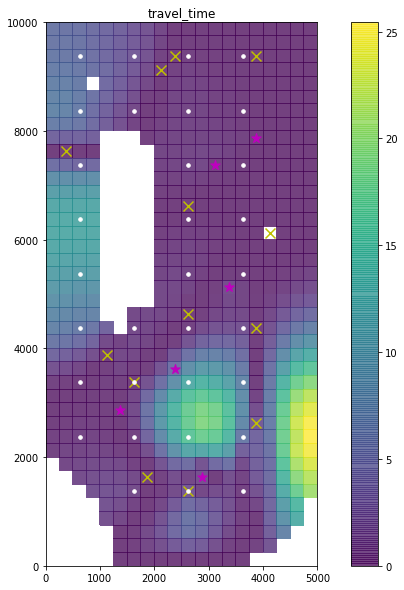

fa_headwaters_0001


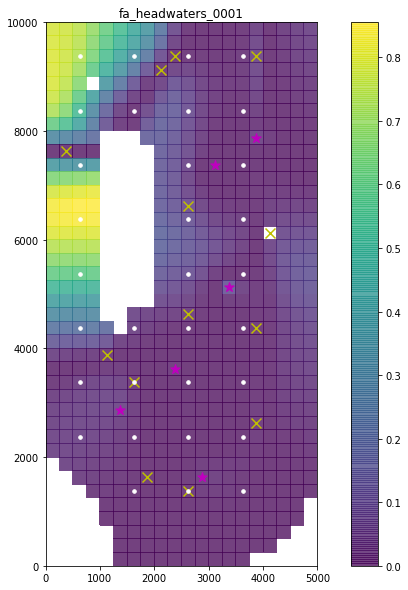

c001fr16c17_19791231


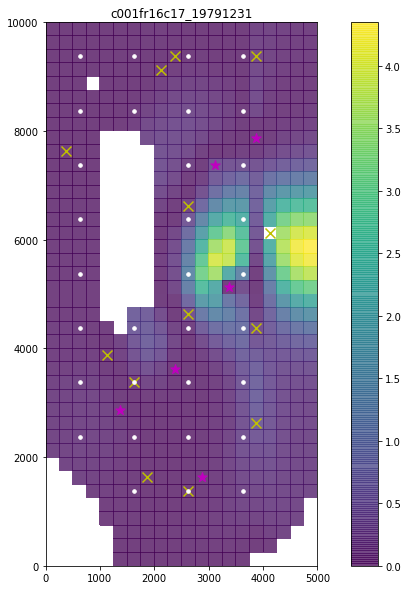

c001fr05c04_19791231


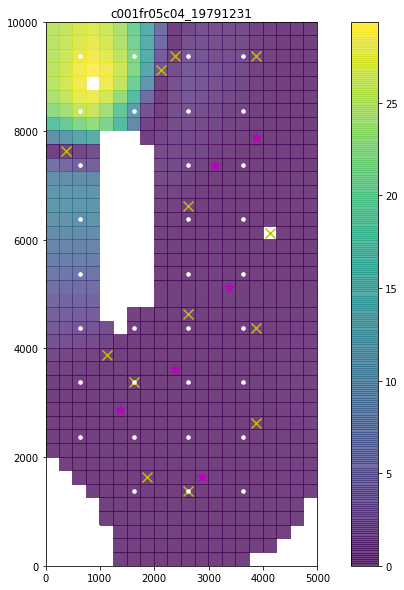

In [33]:
plot_added_worth(df_full)